# Transforming New Data with UMAP

In [1]:
import numpy as np
import anndata as ad
import pandas as pd
from matplotlib import rcParams

import umap.umap_ as umap
import umap.plot

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import os
import config as general_paths

/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path
input_path = output_path

In [3]:
NO_PCA = 20
NO_NEIGHBORS = 15

In [4]:
campari_umap_file = 'campari_umap_from_kallisto.h5ad'
adata_umap_path = os.path.join(input_path,campari_umap_file)
adata_path = os.path.join(input_path,'campari_from_kallisto_excluded_cells_without_some_genes.h5ad')

In [5]:
adata = ad.read_h5ad(adata_path)
adata_umap = ad.read_h5ad(adata_umap_path)

/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModi

In [6]:
adata

AnnData object with n_obs × n_vars = 2069 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'sample_colors', 'stimulus_name_colors'

In [7]:
# get count matrix
x = adata.X

## PCA

In [8]:
# Do PCA first
# 50 PCA was default in scanpy
pca = PCA(n_components=50, svd_solver='arpack')
pca_representation_all = pca.fit_transform(x)


In [9]:
pca_representation_all.shape

(2069, 50)

Choose how many to keep

Text(0.5, 1.0, 'variance ratio')

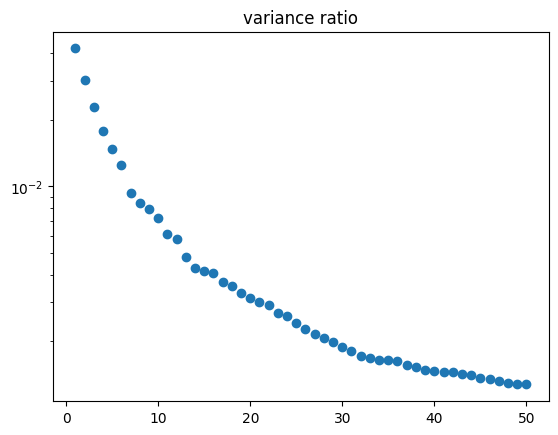

In [10]:
# pca.explained_variance_ratio_
plt.scatter([i+1 for i in range(50)],pca.explained_variance_ratio_)
plt.yscale('log')
plt.title("variance ratio")

In [11]:
# keep only as many as in scanpy (NO_PCA)
pca_representation = pca_representation_all[:,:NO_PCA]
pca_representation.shape

(2069, 20)

## UMAP

In [12]:
# construct a UMAP object
reducer = umap.UMAP(n_components= 2,
                    n_neighbors=NO_NEIGHBORS,
                    min_dist = 0.5,
                    # spread= 1.0, 
                    # init= 'spectral', 
                    # negative_sample_rate=5,
                    random_state=0)
# fit
embedding = reducer.fit_transform(pca_representation)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2069, 2)

Show UMAP

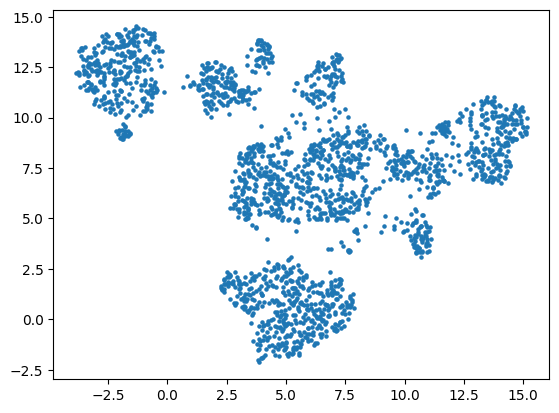

In [13]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=5)

Show UMAP with Louvain labels from adata

In [14]:
# these are my cluster labels
my_labels = adata_umap.obs['louvain_r1']
my_labels

barcode
TCCGATAACTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456     2
TCCGATAACTCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456     4
TTCACCACGGCACAATCCAC-sample1-sample12-sample123-sample1234-sample12345-sample123456     4
TTCACCACGGCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456     4
TTCACCAGCTCACTAACCGG-sample1-sample12-sample123-sample1234-sample12345-sample123456    10
                                                                                       ..
CGGTAACGGTGAGCGGAACT-sample7                                                            0
GACTAGGTCCACCTCACCAG-sample7                                                            7
TCACCACATAACCTCACCAG-sample7                                                            0
AGCTCCACTGCGGTTGGCTA-sample7                                                            0
CGGTTGAACGGAGCGGAACT-sample7                                                            0
Na

<Axes: >

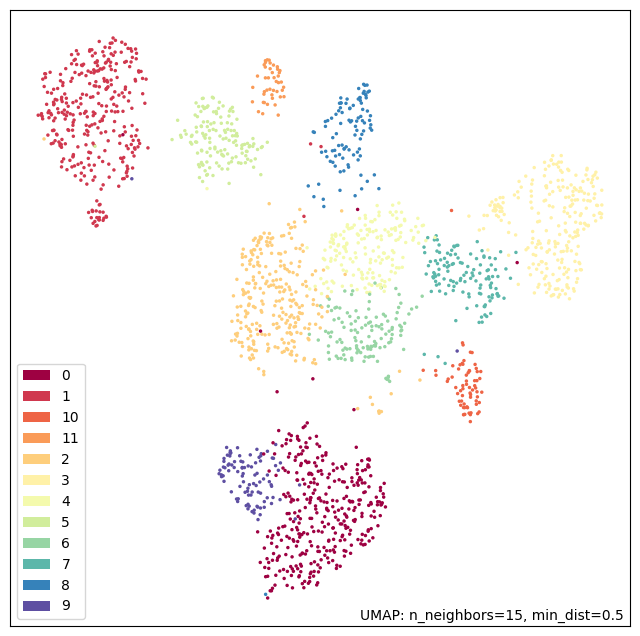

In [15]:

umap.plot.points(reducer, labels=my_labels)

## Example: Transforming new data with UMAP

In [16]:
from sklearn.datasets import load_digits

In [17]:
digits = load_digits()

In [18]:
digits.target.shape

(1797,)

In [19]:
digits.data.shape

(1797, 64)

In [20]:
# train_test_split will carve off 25% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(digits.data, # data
                                                    digits.target, # labels
                                                    stratify=digits.target,
                                                    random_state=42)

In [21]:
X_train

array([[ 0.,  2., 12., ..., 15.,  3.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2., 11., ..., 13., 16.,  1.],
       ...,
       [ 0.,  0.,  1., ..., 16., 10.,  0.],
       [ 0.,  0.,  3., ...,  7.,  0.,  0.],
       [ 0.,  0.,  7., ..., 14.,  6.,  0.]])

In [22]:
y_train

array([2, 1, 2, ..., 9, 8, 9])

In [23]:
# let’s train a couple of different classifiers and then see how well they score on the test set. 
# For this example let’s try a support vector classifier and a KNN classifier
svc_example = SVC().fit(X_train, y_train)
knn_example = KNeighborsClassifier().fit(X_train, y_train)

In [24]:
svc_example.score(X_test, y_test), knn_example.score(X_test, y_test)

(0.9911111111111112, 0.9844444444444445)

In [25]:
trans_example = umap.UMAP(n_neighbors=5, random_state=42).fit(X_train)

/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'Embedding of the training set by UMAP')

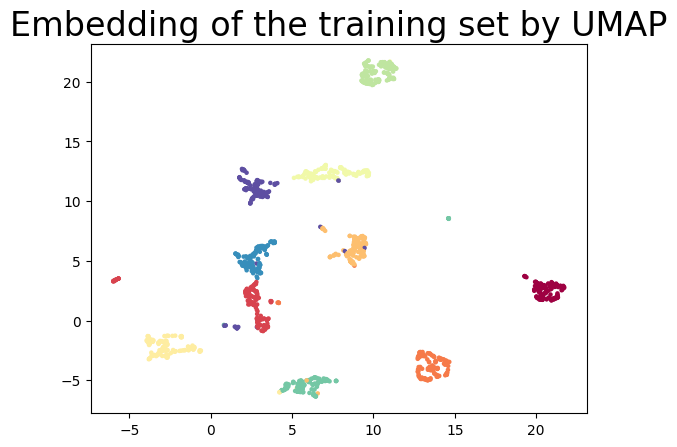

In [26]:
plt.scatter(trans_example.embedding_[:, 0], trans_example.embedding_[:, 1], s= 5, c=y_train, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24)

In [27]:
svc_example = SVC().fit(trans_example.embedding_, y_train)
knn_example = KNeighborsClassifier().fit(trans_example.embedding_, y_train)

In [28]:
# Now we want to work with the test data which none of the models (UMAP or the classifiers) have seen
test_embedding_example = trans_example.transform(X_test)

Text(0.5, 1.0, 'Embedding of the test set by UMAP')

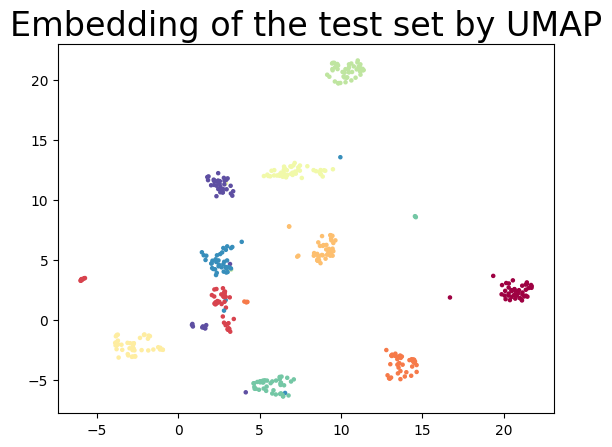

In [29]:
plt.scatter(test_embedding_example[:, 0], test_embedding_example[:, 1], s= 5, c=y_test, cmap='Spectral')
plt.title('Embedding of the test set by UMAP', fontsize=24)

In [31]:
svc_example.score(trans_example.transform(X_test), y_test), knn_example.score(trans_example.transform(X_test), y_test)

(0.9488888888888889, 0.9822222222222222)

## Test on our data

In [32]:
# train_test_split will carve off 25% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(pca_representation, # data
                                                                    my_labels, # labels
                                                                    stratify=my_labels,
                                                                    random_state=0)

In [33]:
# let’s train a couple of different classifiers and then see how well they score on the test set. 
# For this example let’s try a support vector classifier and a KNN classifier
svc = SVC().fit(data_train, labels_train)
knn = KNeighborsClassifier().fit(data_train, labels_train)

In [34]:
svc.score(data_test, labels_test), knn.score(data_test, labels_test)

(0.9652509652509652, 0.9691119691119691)

In [35]:
trans = umap.UMAP(n_components= 2,
                    n_neighbors=NO_NEIGHBORS,
                    min_dist = 0.5,
                    random_state=0).fit(data_train)

/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'Embedding of the training set by UMAP')

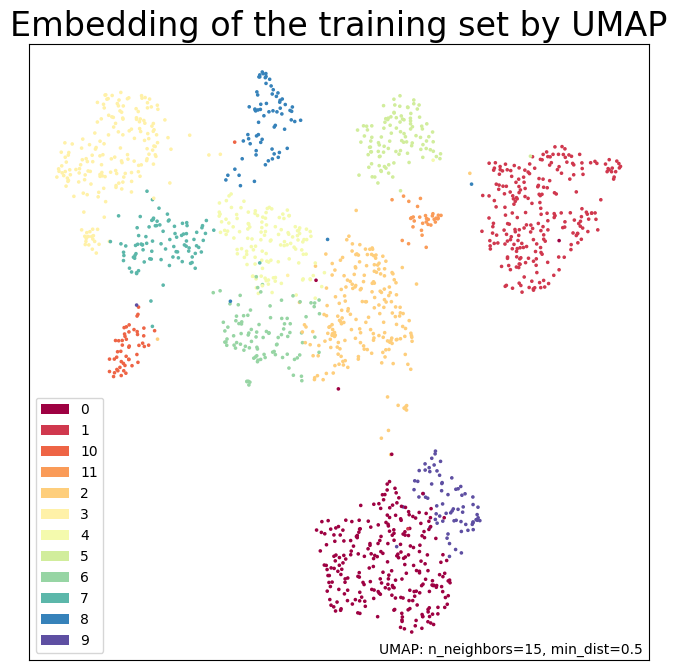

In [36]:
ax = umap.plot.points(trans, labels=labels_train)
ax.set_title('Embedding of the training set by UMAP', fontsize=24)

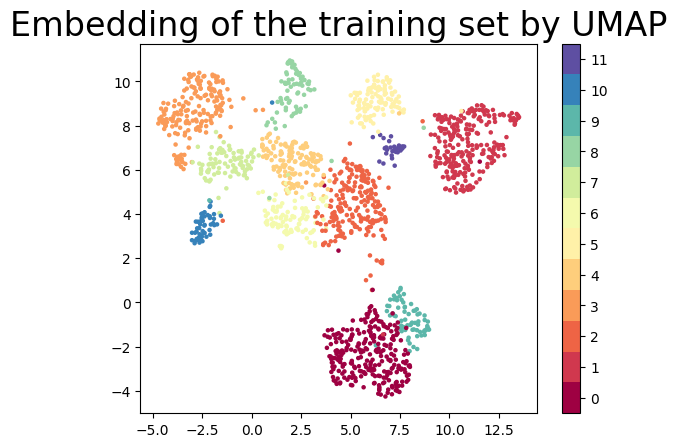

In [43]:
# for the scatter plot colormap we need labels as intigers or colors
labels_train_as_int = [int(el) for el in labels_train.values]
NO_clusters = len(np.unique(labels_train_as_int))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=labels_train_as_int, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24)
plt.colorbar(boundaries=np.arange(NO_clusters+1)-0.5).set_ticks(np.arange(NO_clusters))

In [37]:
# We can now train some new models (again an SVC and a KNN classifier) on the embedded training data. 
# This looks exactly as before but now we pass it the embedded data
svc = SVC().fit(trans.embedding_, labels_train)
knn = KNeighborsClassifier().fit(trans.embedding_, labels_train)

In [38]:
# Now we want to work with the test data which none of the models (UMAP or the classifiers) have seen
test_embedding = trans.transform(data_test)

In [39]:
# for the scatter plot colormap we need labels as intigers or colors
labels_test_as_int = [int(el) for el in labels_test.values]

In [40]:
NO_clusters = len(np.unique(labels_test_as_int))

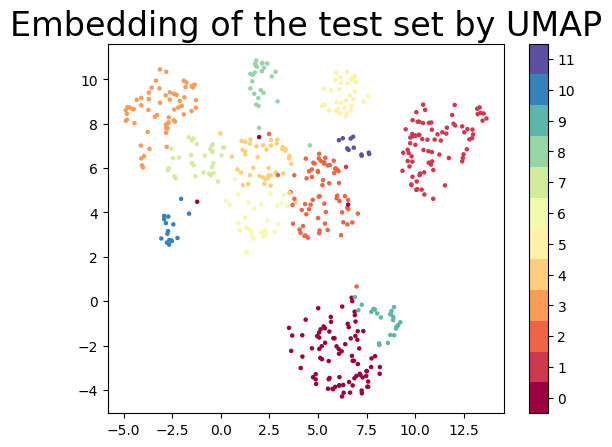

In [41]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=labels_test_as_int, cmap='Spectral')
plt.title('Embedding of the test set by UMAP', fontsize=24)
plt.colorbar(boundaries=np.arange(NO_clusters+1)-0.5).set_ticks(np.arange(NO_clusters))